In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utils

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import random
from google.colab.patches import cv2_imshow

import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 랜덤 시드 설정
seed = 77
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Custom Dataset

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, root_dir, transform=None, infer=False):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'binary_masks')
        self.image_filenames = os.listdir(self.image_dir)

        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace('.jpg', '.tif')) #확장자 명만 다름

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #jpg랑 cv2에서 RGB 순서 다름.

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask/255

        #전처리입니다.
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Define Model

In [5]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 7.7 MB/s eta 0:00:00


## Hyper Parameters

In [7]:
lr= 1e-4
epochs = 100
batch_size = 8


## Data Loader

In [8]:
train_transform = A.Compose(
    [
        A.RandomCrop(384, 384),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
        A.Transpose(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomShadow(shadow_roi=(0, 0, 1, 1), p=0.1),

        A.OneOf([
            # A.ElasticTransform(p=1),
            A.OpticalDistortion(p=1),
            A.GridDistortion(p=1),
        ], p=0.1),
        A.Normalize(),
        ToTensorV2()
    ]
)
test_transform = A.Compose(
    [
        A.CenterCrop(384, 384),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/train', transform=train_transform) #train data 폴더 경로 넣기.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# dataset_size =  len(train_dataset)
# subset_size = int(0.1 * dataset_size )
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# subset_dataset = Subset(train_dataset, subset_indices)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=12)

In [10]:
test_dataset = SatelliteDataset(root_dir='/content/drive/MyDrive/인지프/data/test', transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=12)

# dataset_size =  len(test_dataset)
# # 10%의 Random dataset 데이터셋 생성
# subset_size = int(0.2 * dataset_size)
# subset_indices = torch.randperm(dataset_size)[:subset_size]
# mini_test = Subset(test_dataset, subset_indices)
# mini_test_loader = DataLoader(mini_test, batch_size, shuffle=True, num_workers=16)

## Model Train

In [11]:
# model 초기화
from backbones_unet.model.unet import Unet
model = Unet(
    backbone='tf_efficientnetv2_m_in21ft1k',
    in_channels=3,
    num_classes=1,
).to(device=device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

#### 10%로만 할지 말지 ####
# train_dataloader = subset_dataloader

train_losses = []
test_losses = []

# training loop
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_dataloader):
      images = images.float().to(device)
      masks = masks.float().to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, masks.unsqueeze(1))

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
    train_losses.append(epoch_loss/len(train_dataloader))

    test_loss=0
    with torch.no_grad():
      model.eval()
      result = []
      for images, masks in tqdm(test_dataloader):
          images = images.float().to(device)
          masks = masks.float().to(device)

          outputs = model(images)
          loss = criterion(outputs, masks.unsqueeze(1))
          test_loss += loss.item()
    test_losses.append(test_loss/len(test_dataloader))
    if epoch % 50 == 0:
      torch.save(model.state_dict(), f'./model{epoch}.pt')


    print(f'\nEpoch {epoch+1}, Loss: {epoch_loss/len(train_dataloader)}, Test Loss : {test_loss/len(test_dataloader)}')



Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m_21ft1k-bf41664a.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_m_21ft1k-bf41664a.pth
100%|██████████| 72/72 [00:56<00:00,  1.27it/s]



Epoch 1, Loss: 0.48095005636827814, Test Loss : 0.31586081389751697


100%|██████████| 72/72 [00:07<00:00,  9.13it/s]



Epoch 2, Loss: 0.2988672072792219, Test Loss : 0.27042922667331165


100%|██████████| 72/72 [00:07<00:00,  9.35it/s]



Epoch 3, Loss: 0.25542830324007404, Test Loss : 0.24365943484008312


100%|██████████| 72/72 [00:08<00:00,  8.54it/s]



Epoch 4, Loss: 0.2242663302976224, Test Loss : 0.21038567709426084


100%|██████████| 72/72 [00:08<00:00,  8.92it/s]



Epoch 5, Loss: 0.20274133695703414, Test Loss : 0.19561827275902033


100%|██████████| 72/72 [00:07<00:00,  9.14it/s]



Epoch 6, Loss: 0.17989770656762025, Test Loss : 0.18702303680280843


100%|██████████| 72/72 [00:08<00:00,  8.53it/s]



Epoch 7, Loss: 0.16555341977315643, Test Loss : 0.16424615484558874


100%|██████████| 72/72 [00:07<00:00,  9.20it/s]



Epoch 8, Loss: 0.15659459162917402, Test Loss : 0.1624452417405943


100%|██████████| 72/72 [00:07<00:00,  9.17it/s]



Epoch 9, Loss: 0.14557707948713666, Test Loss : 0.1522852075803611


100%|██████████| 72/72 [00:08<00:00,  8.32it/s]



Epoch 10, Loss: 0.13798630949006313, Test Loss : 0.1480873559291164


100%|██████████| 72/72 [00:07<00:00,  9.66it/s]



Epoch 11, Loss: 0.13588491294326055, Test Loss : 0.14261983391932315


100%|██████████| 72/72 [00:08<00:00,  8.92it/s]



Epoch 12, Loss: 0.12360529345460236, Test Loss : 0.12964150609655511


100%|██████████| 72/72 [00:08<00:00,  8.70it/s]



Epoch 13, Loss: 0.12457770217830937, Test Loss : 0.126802755261047


100%|██████████| 72/72 [00:07<00:00,  9.40it/s]



Epoch 14, Loss: 0.12182614622482409, Test Loss : 0.14103364809933636


100%|██████████| 72/72 [00:08<00:00,  8.74it/s]



Epoch 15, Loss: 0.11702053554149137, Test Loss : 0.12600102495505577


100%|██████████| 72/72 [00:07<00:00,  9.04it/s]



Epoch 16, Loss: 0.1151075823387752, Test Loss : 0.11828421890580405


100%|██████████| 72/72 [00:07<00:00,  9.36it/s]



Epoch 17, Loss: 0.111691486206837, Test Loss : 0.1188990558213037


100%|██████████| 72/72 [00:08<00:00,  8.43it/s]



Epoch 18, Loss: 0.11022874665084398, Test Loss : 0.12162877274547806


100%|██████████| 72/72 [00:07<00:00,  9.30it/s]



Epoch 19, Loss: 0.10566259284193318, Test Loss : 0.11662826556453688


100%|██████████| 72/72 [00:07<00:00,  9.04it/s]



Epoch 20, Loss: 0.10827744739233619, Test Loss : 0.11978837067727


100%|██████████| 72/72 [00:08<00:00,  8.55it/s]



Epoch 21, Loss: 0.10865151250941886, Test Loss : 0.11930985969310212


100%|██████████| 72/72 [00:07<00:00,  9.28it/s]



Epoch 22, Loss: 0.10440061813116902, Test Loss : 0.11309934381602539


100%|██████████| 72/72 [00:08<00:00,  8.81it/s]



Epoch 23, Loss: 0.10287575542719828, Test Loss : 0.11714240833599535


100%|██████████| 72/72 [00:08<00:00,  8.70it/s]



Epoch 24, Loss: 0.10520329810161558, Test Loss : 0.11662963465722795


100%|██████████| 72/72 [00:07<00:00,  9.18it/s]



Epoch 25, Loss: 0.1013053986761305, Test Loss : 0.11213082560506235


100%|██████████| 72/72 [00:08<00:00,  8.48it/s]



Epoch 26, Loss: 0.10287991971320783, Test Loss : 0.10812048769245546


100%|██████████| 72/72 [00:07<00:00,  9.25it/s]



Epoch 27, Loss: 0.10007728434478243, Test Loss : 0.11755310008690383


100%|██████████| 72/72 [00:07<00:00,  9.10it/s]



Epoch 28, Loss: 0.10156082222238183, Test Loss : 0.11185558625665079


100%|██████████| 72/72 [00:08<00:00,  8.77it/s]



Epoch 29, Loss: 0.09796591143822297, Test Loss : 0.11213199516835932


100%|██████████| 72/72 [00:07<00:00,  9.31it/s]



Epoch 30, Loss: 0.09465727892367998, Test Loss : 0.11279901677011771


100%|██████████| 72/72 [00:08<00:00,  8.76it/s]



Epoch 31, Loss: 0.09630705275210655, Test Loss : 0.11348106233829942


100%|██████████| 72/72 [00:07<00:00,  9.25it/s]



Epoch 32, Loss: 0.09534079102256025, Test Loss : 0.10920973010231844


100%|██████████| 72/72 [00:07<00:00,  9.28it/s]



Epoch 33, Loss: 0.10196728512851728, Test Loss : 0.10642284794852862


100%|██████████| 72/72 [00:08<00:00,  8.33it/s]



Epoch 34, Loss: 0.09491630842158985, Test Loss : 0.11010463860455072


100%|██████████| 72/72 [00:07<00:00,  9.16it/s]



Epoch 35, Loss: 0.09198300229359625, Test Loss : 0.10678496405469357


100%|██████████| 72/72 [00:07<00:00,  9.14it/s]



Epoch 36, Loss: 0.09681914727358769, Test Loss : 0.10766060536358661


100%|██████████| 72/72 [00:07<00:00,  9.12it/s]



Epoch 37, Loss: 0.09400019448690324, Test Loss : 0.10741861540494331


100%|██████████| 72/72 [00:07<00:00,  9.29it/s]



Epoch 38, Loss: 0.09230729678852691, Test Loss : 0.10363528323958032


100%|██████████| 72/72 [00:08<00:00,  8.44it/s]



Epoch 39, Loss: 0.08964113644065543, Test Loss : 0.1043695329103179


100%|██████████| 72/72 [00:07<00:00,  9.26it/s]



Epoch 40, Loss: 0.0911509688788404, Test Loss : 0.10499522825476662


100%|██████████| 72/72 [00:08<00:00,  8.85it/s]



Epoch 41, Loss: 0.09180592372366744, Test Loss : 0.10372187942913216


100%|██████████| 72/72 [00:07<00:00,  9.02it/s]



Epoch 42, Loss: 0.08991148205111837, Test Loss : 0.1064306117340392


100%|██████████| 72/72 [00:07<00:00,  9.13it/s]



Epoch 43, Loss: 0.09165003286519398, Test Loss : 0.10784286406366543


100%|██████████| 72/72 [00:08<00:00,  8.40it/s]



Epoch 44, Loss: 0.08860445302949908, Test Loss : 0.10476197209775112


100%|██████████| 72/72 [00:07<00:00,  9.24it/s]



Epoch 45, Loss: 0.09252566828056136, Test Loss : 0.11212007679569069


100%|██████████| 72/72 [00:07<00:00,  9.24it/s]



Epoch 46, Loss: 0.08954617705765283, Test Loss : 0.10427031119050095


100%|██████████| 72/72 [00:08<00:00,  8.56it/s]



Epoch 47, Loss: 0.08798010759831716, Test Loss : 0.10063209623897112


100%|██████████| 72/72 [00:07<00:00,  9.46it/s]



Epoch 48, Loss: 0.08568174221889219, Test Loss : 0.1073234086789954


100%|██████████| 72/72 [00:08<00:00,  8.83it/s]



Epoch 49, Loss: 0.08716744050616398, Test Loss : 0.10323144450214589


100%|██████████| 72/72 [00:07<00:00,  9.05it/s]



Epoch 50, Loss: 0.087863265168077, Test Loss : 0.10404487919570077


100%|██████████| 72/72 [00:07<00:00,  9.07it/s]



Epoch 51, Loss: 0.08865870075856543, Test Loss : 0.10992117436479829


100%|██████████| 72/72 [00:08<00:00,  8.98it/s]



Epoch 52, Loss: 0.08592816677022104, Test Loss : 0.10340839529655771


100%|██████████| 72/72 [00:07<00:00,  9.22it/s]



Epoch 53, Loss: 0.0853595069816543, Test Loss : 0.1044874049055377


100%|██████████| 72/72 [00:08<00:00,  8.59it/s]



Epoch 54, Loss: 0.08681266385570376, Test Loss : 0.11114703124460196


100%|██████████| 72/72 [00:07<00:00,  9.19it/s]



Epoch 55, Loss: 0.0843064916617651, Test Loss : 0.1006730482388068


100%|██████████| 72/72 [00:08<00:00,  8.70it/s]



Epoch 56, Loss: 0.08562979087906165, Test Loss : 0.10386127806769865


100%|██████████| 72/72 [00:08<00:00,  8.86it/s]



Epoch 57, Loss: 0.0842446435126476, Test Loss : 0.11115832026714795


100%|██████████| 72/72 [00:07<00:00,  9.10it/s]



Epoch 58, Loss: 0.08469726115193528, Test Loss : 0.10263475303832416


100%|██████████| 72/72 [00:08<00:00,  8.50it/s]



Epoch 59, Loss: 0.08913731669761343, Test Loss : 0.10644926445254693


100%|██████████| 72/72 [00:07<00:00,  9.43it/s]



Epoch 60, Loss: 0.08459780562487948, Test Loss : 0.1041686341316866


100%|██████████| 72/72 [00:08<00:00,  8.85it/s]



Epoch 61, Loss: 0.08693295102178429, Test Loss : 0.1064458616237971


100%|██████████| 72/72 [00:08<00:00,  8.97it/s]



Epoch 62, Loss: 0.08743717853859481, Test Loss : 0.10637520361746687


100%|██████████| 72/72 [00:07<00:00,  9.32it/s]



Epoch 63, Loss: 0.08250384686592345, Test Loss : 0.10174437223354794


100%|██████████| 72/72 [00:08<00:00,  8.18it/s]



Epoch 64, Loss: 0.08259463393025929, Test Loss : 0.10808992290549213


100%|██████████| 72/72 [00:07<00:00,  9.27it/s]



Epoch 65, Loss: 0.08200782328882876, Test Loss : 0.09999019559877019


100%|██████████| 72/72 [00:08<00:00,  8.96it/s]



Epoch 66, Loss: 0.08164521688336714, Test Loss : 0.10291323429070569


100%|██████████| 72/72 [00:08<00:00,  8.87it/s]



Epoch 67, Loss: 0.08184045153514792, Test Loss : 0.10127672583540617


100%|██████████| 72/72 [00:07<00:00,  9.18it/s]



Epoch 68, Loss: 0.08246902285868095, Test Loss : 0.10884234949319055


100%|██████████| 72/72 [00:08<00:00,  8.40it/s]



Epoch 69, Loss: 0.08208134853177601, Test Loss : 0.10756981700251345


100%|██████████| 72/72 [00:07<00:00,  9.35it/s]



Epoch 70, Loss: 0.0823915009580863, Test Loss : 0.10764623015954082


100%|██████████| 72/72 [00:08<00:00,  8.52it/s]



Epoch 71, Loss: 0.07996734994877544, Test Loss : 0.10092343240830814


100%|██████████| 72/72 [00:08<00:00,  8.86it/s]



Epoch 72, Loss: 0.0821158916159119, Test Loss : 0.10717540516149408


100%|██████████| 72/72 [00:07<00:00,  9.00it/s]



Epoch 73, Loss: 0.07998461927571851, Test Loss : 0.10239269910946153


100%|██████████| 72/72 [00:08<00:00,  8.46it/s]



Epoch 74, Loss: 0.08006369264654091, Test Loss : 0.10293231179336242


100%|██████████| 72/72 [00:07<00:00,  9.25it/s]



Epoch 75, Loss: 0.0821349652542267, Test Loss : 0.10463230281715773


100%|██████████| 72/72 [00:08<00:00,  8.80it/s]



Epoch 76, Loss: 0.07934559682487613, Test Loss : 0.100665442206567


100%|██████████| 72/72 [00:07<00:00,  9.08it/s]



Epoch 77, Loss: 0.08236888758902852, Test Loss : 0.11075507020804151


100%|██████████| 72/72 [00:07<00:00,  9.40it/s]



Epoch 78, Loss: 0.08101378711419077, Test Loss : 0.1009059037460247


100%|██████████| 72/72 [00:08<00:00,  8.41it/s]



Epoch 79, Loss: 0.07894007429260658, Test Loss : 0.10178044523652513


100%|██████████| 72/72 [00:07<00:00,  9.02it/s]



Epoch 80, Loss: 0.07975247521729519, Test Loss : 0.09998331294870393


100%|██████████| 72/72 [00:07<00:00,  9.04it/s]



Epoch 81, Loss: 0.0788185070333485, Test Loss : 0.10568702480183371


100%|██████████| 72/72 [00:07<00:00,  9.02it/s]



Epoch 82, Loss: 0.08075259580639088, Test Loss : 0.1001249379437973


100%|██████████| 72/72 [00:07<00:00,  9.30it/s]



Epoch 83, Loss: 0.07936650544999996, Test Loss : 0.09944808842071022


100%|██████████| 72/72 [00:08<00:00,  8.45it/s]



Epoch 84, Loss: 0.07820928266220209, Test Loss : 0.09910804846003884


100%|██████████| 72/72 [00:07<00:00,  9.09it/s]



Epoch 85, Loss: 0.07632760998482506, Test Loss : 0.10257956779241795


100%|██████████| 72/72 [00:08<00:00,  8.97it/s]



Epoch 86, Loss: 0.07819492448147179, Test Loss : 0.09819546315945142


100%|██████████| 72/72 [00:08<00:00,  8.78it/s]



Epoch 87, Loss: 0.08065416524510106, Test Loss : 0.09961662544487303


100%|██████████| 72/72 [00:07<00:00,  9.48it/s]



Epoch 88, Loss: 0.07756644896128112, Test Loss : 0.102913989978131


100%|██████████| 72/72 [00:08<00:00,  8.53it/s]



Epoch 89, Loss: 0.07975156215899107, Test Loss : 0.09876850506488052


100%|██████████| 72/72 [00:07<00:00,  9.32it/s]



Epoch 90, Loss: 0.07623762451759022, Test Loss : 0.0987480758218832


100%|██████████| 72/72 [00:07<00:00,  9.15it/s]



Epoch 91, Loss: 0.0766918236460899, Test Loss : 0.09984917032690849


100%|██████████| 72/72 [00:08<00:00,  8.59it/s]



Epoch 92, Loss: 0.07751369825887701, Test Loss : 0.10000838652922539


100%|██████████| 72/72 [00:07<00:00,  9.43it/s]



Epoch 93, Loss: 0.07668340373654953, Test Loss : 0.09885638601796624


100%|██████████| 72/72 [00:08<00:00,  8.50it/s]



Epoch 94, Loss: 0.07472268072241503, Test Loss : 0.10011961399626064


100%|██████████| 72/72 [00:07<00:00,  9.19it/s]



Epoch 95, Loss: 0.0765726945860984, Test Loss : 0.0994685560411502


100%|██████████| 72/72 [00:08<00:00,  8.99it/s]



Epoch 96, Loss: 0.07414228490476187, Test Loss : 0.10089602758186327


100%|██████████| 72/72 [00:08<00:00,  8.91it/s]



Epoch 97, Loss: 0.07795089884570593, Test Loss : 0.09906471710241425


100%|██████████| 72/72 [00:07<00:00,  9.27it/s]



Epoch 98, Loss: 0.07538594482078527, Test Loss : 0.1020418275851019


100%|██████████| 72/72 [00:08<00:00,  8.52it/s]



Epoch 99, Loss: 0.07395269798386532, Test Loss : 0.11041667239139012


100%|██████████| 72/72 [00:07<00:00,  9.44it/s]


Epoch 100, Loss: 0.07874399022613135, Test Loss : 0.09925178727361425


In [12]:
torch.save(model.state_dict(), './eff_m.pt')

## Epoch에 따른 Loss 변화

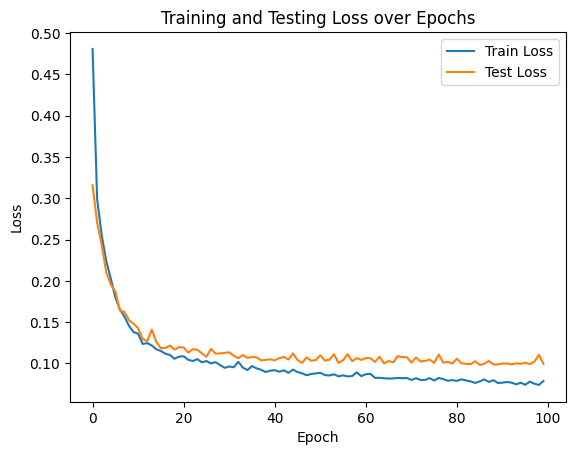

In [13]:

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 잘 되는지 결과 이미지 출력해보기

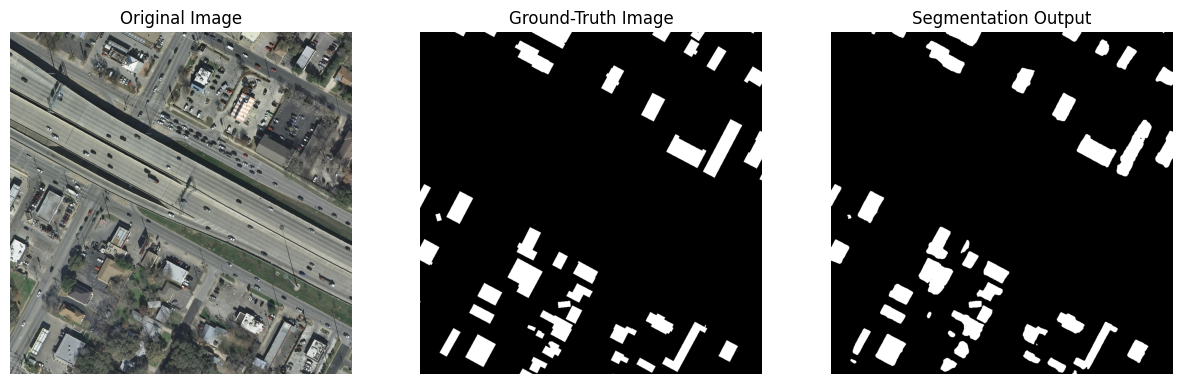

In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 모델 인스턴스 생성 및 가중치 로드
model_trained = model # Unet
# model_trained = Unet_resnet.to(device) # Unet + Resnet
# model_trained.load_state_dict(torch.load('./model.pt')) # 가중치파일 경로
model_trained.eval() # 평가 모드로 설정

# 이미지 전처리
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ])
    input_tensor = preprocess(image=np.array(input_image))['image']
    input_batch = input_tensor.unsqueeze(0) # 배치 차원 추가
    return input_batch

# 이미지 경로
image_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/images/austin1_0_0.jpg'
gt_path = '/content/drive/MyDrive/인지프/inria/cropped_1024/austin1/binary_masks/austin1_0_0.tif'

# 이미지 전처리 및 예측 수행
with torch.no_grad():
    input_batch = preprocess_image(image_path)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model_trained.to('cuda')

    output = model_trained(input_batch)

# 결과 처리
output = torch.sigmoid(output).squeeze(0).permute(1,2,0).cpu().numpy() # Sigmoid 적용 및 이미지 형태로 변환
output = (output > 0.5).astype(np.uint8) # Threshold 적용

# 원본 이미지 보기
plt.figure(figsize=(15, 5))  # 전체 그림의 크기를 늘림

original_image = Image.open(image_path)
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.axis('off')
plt.title("Original Image")

# ground truth 이미지 보기
gt_image = Image.open(gt_path)
plt.subplot(1, 3, 2)
plt.imshow(gt_image)
plt.axis('off')
plt.title("Ground-Truth Image")

# 결과 이미지 보기 (Matplotlib 사용)
plt.subplot(1, 3, 3)
plt.imshow(output, cmap='gray')  # 'gray'는 흑백 이미지인 경우 사용
plt.axis('off')  # 축 제거
plt.title("Segmentation Output")

plt.show()


In [15]:
# model = Unet_resnet.to(device) # Unet + Resnet
# model.load_state_dict(torch.load('./model50.pt')) # 가중치파일 경로
model.eval() # 평가 모드로 설정

all_true_masks = []
all_predicted_masks = []
with torch.no_grad():
    model.eval()
    result = []
    for images, masks in tqdm(test_dataloader):
        images = images.float().to(device)
        true_masks = masks.float().to(device)

        outputs = model(images)

        # CPU로 이동
        true_masks = true_masks.squeeze().cpu().numpy()
        outputs = outputs.squeeze().cpu().numpy()
        outputs = (outputs > 0.5).astype(np.uint8)


        # 리스트에 추가
        all_true_masks.extend(true_masks)
        all_predicted_masks.extend(outputs)

# 실제 마스크와 예측 마스크 비교
true_masks_flat = np.concatenate(all_true_masks).ravel()
predicted_masks_flat = np.concatenate(all_predicted_masks).ravel()

# Precision, Recall, IoU, Dice 계산
# precision = precision_score(true_masks_flat, predicted_masks_flat)
# recall = recall_score(true_masks_flat, predicted_masks_flat)
iou = jaccard_score(true_masks_flat, predicted_masks_flat)
dice_coefficient = f1_score(true_masks_flat, predicted_masks_flat)

# 결과 출력
# print(f'Precision: {precision}')
# print(f'Recall: {recall}')
print(f'IoU: {iou}')
print(f'Dice Coefficient: {dice_coefficient}')



  0%|          | 0/72 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 72/72 [00:08<00:00,  8.95it/s]


Precision: 0.9155725355387889
Recall: 0.8512695655835202
IoU: 0.7893103521644593
Dice Coefficient: 0.8822509199811661
